In [1]:
import snntorch as snn
import sys
import platform
import torch
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import math

has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: macOS-13.2.1-arm64-arm-64bit
PyTorch Version: 2.0.0.dev20230210

Python 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:38:11) 
[Clang 14.0.6 ]
Pandas 1.5.3
Scikit-Learn 1.2.1
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


In [2]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Simplifying LIF model

LIF model previously established had a lot of hyperparameters to tune ($R, C, \triangle t, U_{thr}$).

## Decay Rate: Beta 

Euler method was used to derive the following solution to the passive membrane model:

$$U(t+\triangle t) = (1-\frac{\triangle t}{\tau})U(t) + \frac{\triangle t}{\tau}I_{in}(t)R$$

Now assume there is no input current, $I_{in}(t) = 0A$:

$$U(t+\triangle t) = (1-\frac{\triangle t}{\tau})U(t)$$

Let the ratio of subsequent values of U, i.e., $U(t+\triangle t)/U(t)$ be $\beta$, the decay rate of the membrane potential AKA the inverse time constant:

$$
U(t+\triangle t) = \beta U(t)
\\
\beta = (1-\frac{\triangle t}{\tau})
$$

## Weighted Input Current + Spiking And Reset

Refer to pdf note for math. Below is the simplified neuron in python: 







In [14]:
def leaky_integrate_and_fire(mem, x, w, beta, threshold=1):
    spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else 0 
    mem = beta * mem + w*x - spk*threshold 
    return spk, mem 

def plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line, title, vline=None):
    # plot current input
    fig1, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(cur_in, 'b')
    ax1.set_ylabel('Current (Amps)')
    ax1.set_title(title)

    # plot membrane potential
    fig2, ax2 = plt.subplots(figsize=(10, 5))
    ax2.plot(mem_rec, 'r', label='Membrane Potential')
    ax2.axhline(y=thr_line, color='g', linestyle='--', label='Threshold')
    if vline:
       ax2.axvline(x=vline, color='m', linestyle='--', label='Spiking Time')
    ax2.set_ylabel('Membrane Potential (V)')
    ax2.set_xlabel('Time (ms)')
    # ax2.set_ylim(top=ylim_max2)
    ax2.legend()

    # plot spikes
    fig3, ax3 = plt.subplots(figsize=(10, 5))
    splt.raster(spk_rec, ax3, s=100, c="black", marker="|")
    ax3.set_ylabel("Output Spikes")
    ax3.set_xlabel("Time step")
    ax3.set_yticks([])

    plt.show()


In [15]:
# set neuronal parameters
delta_t = torch.tensor(1e-3)
tau = torch.tensor(5e-3)
beta = torch.exp(-delta_t/tau)

In [16]:
print(f"The decay rate is: {beta:.3f}")

The decay rate is: 0.819


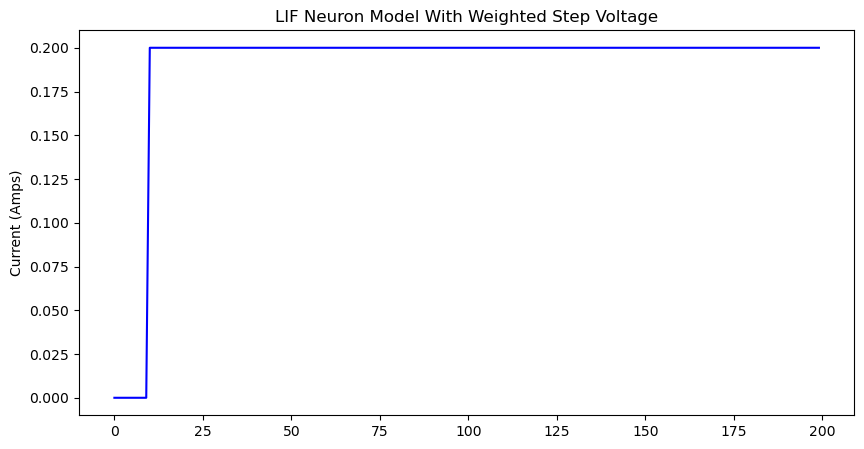

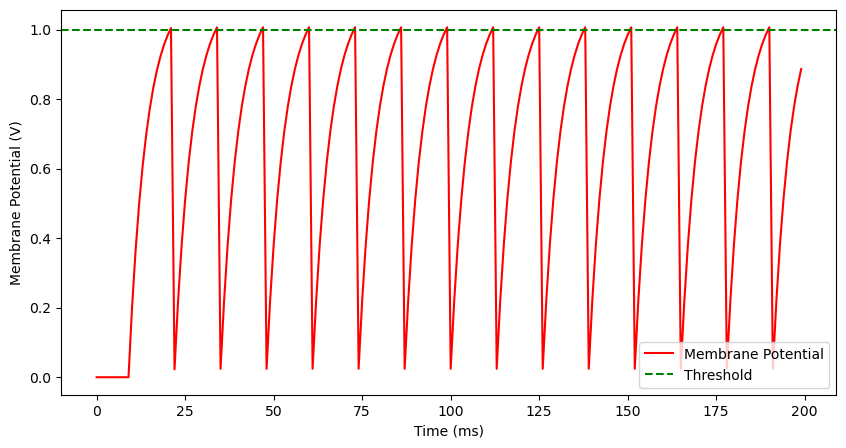

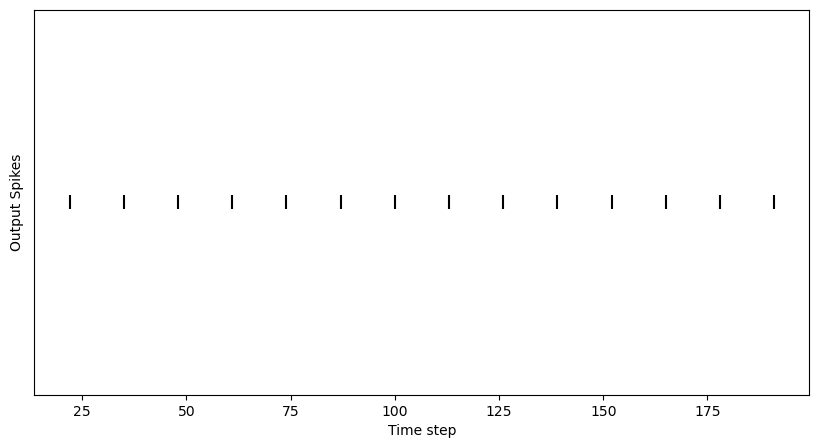

In [17]:
num_steps = 200

# initialize inputs/outputs + small step current input
x = torch.cat((torch.zeros(10), torch.ones(190)*0.5), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron parameters
w = 0.4
beta = 0.819

# neuron simulation
for step in range(num_steps):
  spk, mem = leaky_integrate_and_fire(mem, x[step], w=w, beta=beta)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(x*w, mem_rec, spk_rec, thr_line=1,
                 title="LIF Neuron Model With Weighted Step Voltage")

`snn.leaky` achieves the same as the code above:

In [18]:
lif1 = snn.Leaky(beta=0.8)

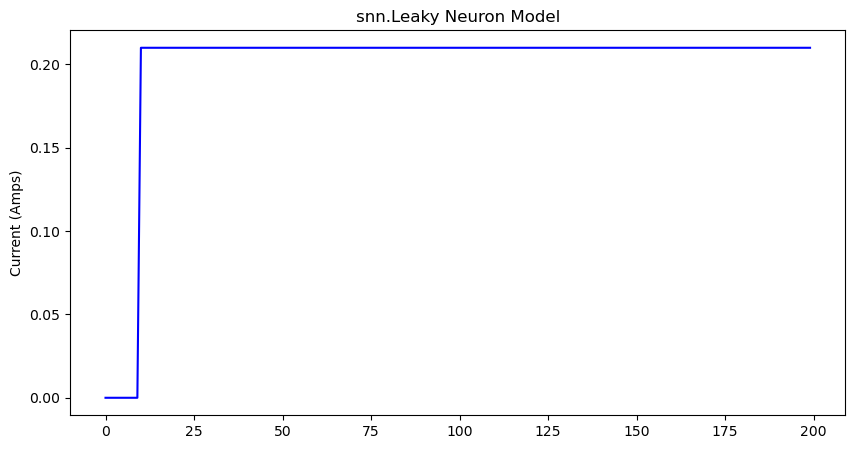

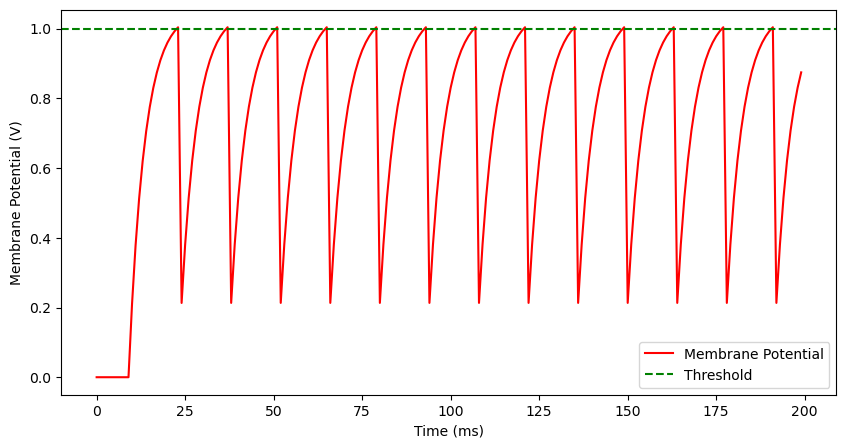

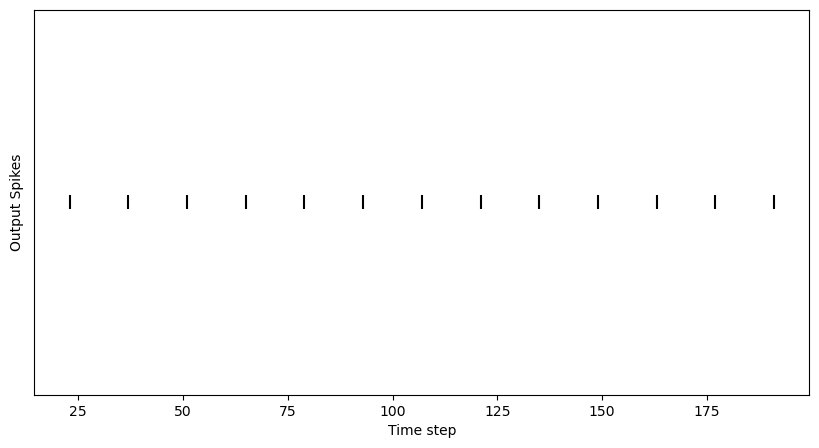

In [20]:
# Small step current input
w=0.21
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*w), 0)
mem = torch.zeros(1)
spk = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
  spk, mem = lif1(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1,
                 title="snn.Leaky Neuron Model")

The membrane potential of `lif1` never actually drops by $S[t]$ because it uses a soft reset, where beta also weights the spike reset. 

# Feedforward SNN

<img src="https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_8_fcn.png?raw=true" width="500">

In [96]:
# layer parameters 
num_inputs = 784
num_hidden = 1000
num_outputs = 10
beta = 0.99

# initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)
lif1 = snn.Leaky(beta=beta)
fc2 = nn.Linear(num_hidden, num_outputs)
lif2 = snn.Leaky(beta=beta)

Static method `init_leaky()` can be used to initialize hidden variables and outputs of each neuron. Shape of the hidden states are automatically initialized based on the input data dimensions during the first forward pass.

In [97]:
# Initialize hidden states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

# record outputs 
mem2_rec = []
spk1_rec = []
spk2_rec = []

There are 200 time steps to simulate across 784 input neurons, i.e., the input originally has dimensions of $200 \times 784$. However, neural nets typically process data in minibatches. snnTorch, uses time-first dimensionality:

$$ [time \times batch\_size \times feature\_dimensions] $$



In [98]:
spk_in = spikegen.rate_conv(torch.rand((200, 784))).unsqueeze(1)
print(f"Dimensions of spk_in: {spk_in.size()}")

Dimensions of spk_in: torch.Size([200, 1, 784])


PytTorch routes neurons together, snnTorch loads the results into spiking neuron models. In terms of coding up a network, these spiking neurons can be treated like time-varying activation functions. 

**Sequential Process**:
- the $i^{th}$ input from `spk_in` to the $j^{th}$ neuron is weighted by the parameters initialized in `nn.Linear()`: $X_{i} \times W_{ij}$
- this generates the input current term from the Equation (10), contributing to $U[t+1]$ of the spiking neuron 
- if $U[t+1] > U_thr$, then a spike triggered from this neuron (activation function type beat)
- this spike is weighted by the second layer weight, and the above process is repeated for all inputs, weights, and neurons 
- if there is no spike, then nothing is passed to the post-synaptic neuron 

The main difference from the previous neuron simulations thus far is the addition of `nn.Linear` which generates the weight, instead of manually setting $W$.


In [99]:
# network simulation
for step in range(num_steps):
    cur1 = fc1(spk_in[step]) # post-synaptic current <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem[t+1] <--post-syn current + decayed membrane
    cur2 = fc2(spk1)
    spk2, mem2 = lif2(cur2, mem2)

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

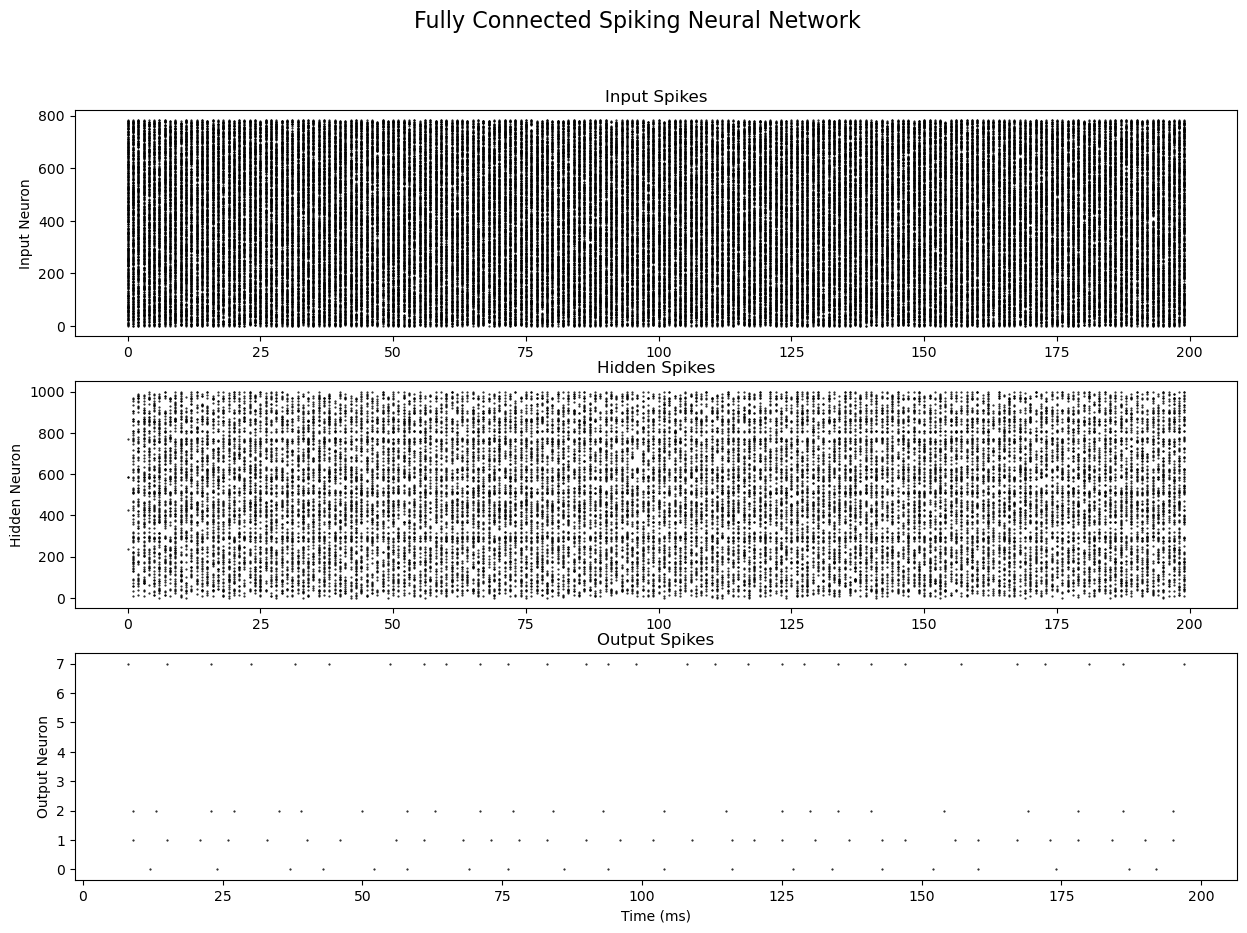

In [109]:
def plot_snn_spikes(spk_in, spk1, spk2, title):
    fig, axs = plt.subplots(3, 1, figsize=(15, 10))
    splt.raster(spk_in.squeeze(1), ax=axs[0], s=1, c="black", marker=".")
    axs[0].set_ylabel('Input Neuron')
    axs[0].set_title('Input Spikes')
    splt.raster(spk1.squeeze(1), ax=axs[1], s=1, c="black", marker=".")
    axs[1].set_ylabel('Hidden Neuron')
    axs[1].set_title('Hidden Spikes')
    splt.raster(spk2.squeeze(1), ax=axs[2], s=1, c="black", marker=".")
    axs[2].set_xlabel('Time (ms)')
    axs[2].set_ylabel('Output Neuron')
    axs[2].set_title('Output Spikes')
    fig.suptitle(title, fontsize=16)
    plt.show()


plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network")

<img src="https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial3/_static/mlp_raster.png?raw=true">

In [107]:
print(spk_in.size())
print(spk1_rec.size())
print(spk2_rec.size())
print(len([100]*spk_in.size()[-1]))

torch.Size([200, 1, 784])
torch.Size([200, 1, 1000])
torch.Size([200, 1, 10])
784


In [110]:
from IPython.display import HTML

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
spk2_rec = spk2_rec.squeeze(1).detach().cpu()

plt.rcParams['animation.ffmpeg_path'] = '/Users/anushmutyala/opt/miniconda3/envs/torch/bin/ffmpeg'

#  Plot spike count histogram
anim = splt.spike_count(spk2_rec, fig, ax, labels=labels, animate=True)
plt.close()
HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

# fig, ax = plt.subplots()
# anim = splt.animator(spike_data_sample, fig, ax)
# plt.rcParams['animation.ffmpeg_path'] = '/Users/anushmutyala/opt/miniconda3/envs/torch/bin/ffmpeg'
# plt.close()

# HTML(anim.to_html5_video())

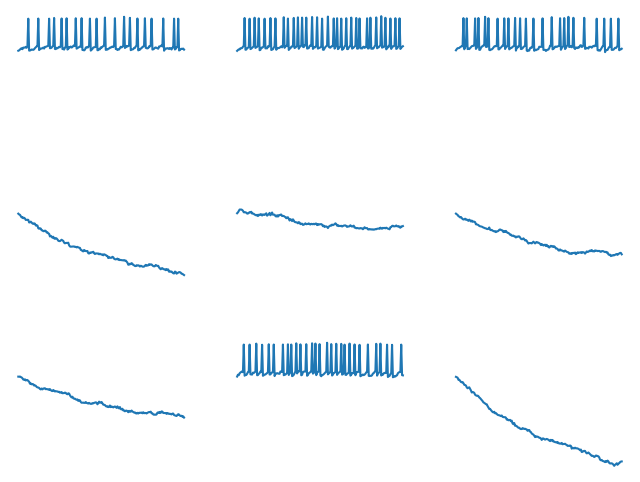

In [111]:
# plot membrane potential traces
splt.traces(mem2_rec.squeeze(1), spk=spk2_rec.squeeze(1))
fig = plt.gcf()
fig.set_size_inches(8, 6)